In [2]:
import torch
from config import *

In [569]:
from datasets import *
B = 2
shuffle = 1
dataset = ToyData(split = "train", resolution = (128,128))
dataloader = DataLoader(dataset, batch_size = B, shuffle = shuffle)


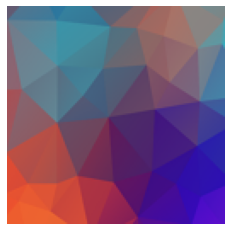

In [570]:
# [Get A Sample Data]
for sample in dataloader:
    sample = sample
plt.axis("off")
plt.imshow(sample["image"][0])

In [571]:
config.perception = "valkyr"
model = SceneLearner(config)


In [572]:
import torch
import torch.nn as nn
from types import SimpleNamespace

class GraphConvolution(nn.Module):

    def __init__(self, input_feature_num, output_feature_num, add_bias=True, dtype=torch.float,
                 batch_normal=True):
        super().__init__()
        # shapes

        self.input_feature_num = input_feature_num
        self.output_feature_num = output_feature_num
        self.add_bias = add_bias
        self.batch_normal = batch_normal

        # params
        self.weight = nn.Linear( input_feature_num, self.output_feature_num)
        self.bias = nn.Parameter(torch.zeros(self.output_feature_num,dtype=dtype))
        self.transform = nn.Linear(self.output_feature_num, self.output_feature_num)
        
        self.sparse = True
        #self.batch_norm = nn.BatchNorm1d(num_features = input_feature_num)
            
    def set_trainable(self, train=True):
        for param in self.parameters():
            param.requires_grad = train

    def forward(self, x, adj):
        """
        @param inp : adjacent: (batch, graph_num, graph_num) cat node_feature: (batch, graph_num, in_feature_num) -> (batch, graph_num, graph_num + in_feature_num)
        @return:
        """
        B, N, D = x.shape
        node_feature = x

        x = self.weight(node_feature)
        #x = torch.nn.functional.normalize(x,p = 1.0, dim = -1, eps = 1e-5)

        if self.sparse or isinstance(adj, torch.SparseTensor):
            x = torch.spmm(adj,x[0]).unsqueeze(0)
        else:
            x = torch.matmul(adj,x[0])
        #if self.add_bias:
        #x = x + self.bias.unsqueeze(0).unsqueeze(0).repeat(B,N,1)

        #x = self.transform(x)

        #x = torch.nn.functional.normalize(x,p = 1.0, dim = -1, eps = 1e-5)

        return x

class GNNSoftPooling(nn.Module):
    def __init__(self, input_feat_dim, output_node_num = 10):
        super().__init__()
        self.assignment_net = GraphConvolution(input_feat_dim, output_node_num)
        self.feature_net =   GraphConvolution(input_feat_dim, input_feat_dim) 
    
    def forward(self, x, adj):
        B,N,D = x.shape
        # B,N,N = adj.shape
        if isinstance(adj, list):
            output_node_features = []
            output_new_adj = []
            output_s_matrix = []
            for i in range(len(adj)):
                s_matrix = self.assignment_net(x[i:i+1], adj[i]) #[B,N,M]
                
                s_matrix = torch.softmax(s_matrix , dim = 2)#.clamp(0.0+eps,1.0-eps)
            
                node_features = self.feature_net(x[i:i+1],adj[i]) #[B,N,D]
                node_features = torch.einsum("bnm,bnd->bmd",s_matrix,node_features) #[B,M,D]
                # [Calculate New Cluster Adjacency]

                # a[i,j] = 
                # s[j,k]

                adj[i] = torch.Tensor.to_dense(adj[i])
                print("smt,adj",s_matrix.max(),s_matrix.min(), adj[i].max(), adj[i].min())
                print(adj[i].shape, s_matrix.shape)
                new_adj = torch.spmm(
                    torch.spmm(
                        s_matrix[0].permute(1,0),adj[i]
                        ),s_matrix[0])
                print("new_adj",new_adj[i].max(), new_adj[i].min())

                output_node_features.append(node_features)
                output_new_adj.append(new_adj)
                output_s_matrix.append(s_matrix)

            output_node_features = torch.cat(output_node_features, dim = 0)
            output_s_matrix = torch.cat(output_s_matrix, dim = 0)
        return output_node_features,output_new_adj,output_s_matrix

class ObjectRender(nn.Module):
    def __init__(self,):
        super().__init__()

def make_fourier_features(grid, n = 32):
    return

class ValkyrNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        device = config.device
        # construct the grid domain connection
        self.imsize = config.imsize
        self.perception_size = config.perception_size
        # build the connection graph for the grid domain
        self.spatial_coords = grid(self.imsize,self.imsize,device=device)
        self.spatial_fourier_features = make_fourier_features(self.spatial_coords)
        self.spatial_edges =  build_perception(self.imsize,self.perception_size,device = device)
        # [Grid Convs]
        conv_feature_dim = config.conv_feature_dim
        self.grid_convs = RDN(SimpleNamespace(G0=conv_feature_dim  ,RDNkSize=3,n_colors=3,RDNconfig=(4,3,16),scale=[2],no_upsampling=True))
        
        # [Diff Pool Construction]
        hierarchy_nodes = config.hierarchy_construct 
        self.diff_pool = nn.ModuleList([
            GNNSoftPooling(input_feat_dim = conv_feature_dim+2,output_node_num = node_num ) for node_num in hierarchy_nodes
        ])
        

        # [Render Fields]
        self.render_fields = nn.ModuleList([])

        self.conv2object_feature = nn.Linear(conv_feature_dim + 2, config.object_dim)
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
    
    def forward(self, x, verbose = 0):
        outputs = {}
        B,W,H,C = x.shape # input shape

        # [Grid Convolution] produce initial feature in the grid domain 
        grid_conv_feature = self.grid_convs(x.permute(0,3,1,2))
        _,_,_,D = grid_conv_feature.shape
        coords_added_conv_feature = torch.cat(
            [grid_conv_feature, self.spatial_coords.unsqueeze(0).repeat(B,1,1,1)], dim = 3
        )
        if verbose:print("coords_added_conv_feature:{}x{}x{}x{}".format(*list(coords_added_conv_feature.shape) ))

        coords_added_conv_feature = coords_added_conv_feature.reshape(B,W*H,(D+2))
        coords_added_conv_feature = F.normalize(coords_added_conv_feature, dim = -1)
       
        # [DiffPool] each layer performs differentiable [Pn invariant] pooling 

        convs_features = []
        cluster_assignments = []
        curr_x = coords_added_conv_feature # base layer feature
  
        curr_edges = [self.spatial_edges for _ in range(B)] # base layer edges
        convs_features.append(curr_x)
        entropy_regular = 0 # initialize the entropy loss
        scene_tree = {
            "x":[curr_x],
            "object_features":[self.conv2object_feature(curr_x)],
            "object_scores":[torch.ones(B,curr_x.shape[1]).to(self.device)],
            "connections":[],
            "edges":[self.spatial_edges]}
        for graph_pool in self.diff_pool:
            curr_x, curr_edges, assignment_matrix = graph_pool(curr_x, curr_edges)
            B,N,M = assignment_matrix.shape
            assignment_matrix = torch.min(scene_tree["object_scores"][-1].unsqueeze(2).repeat(1,1,M), assignment_matrix)

            
            cluster_assignments.append(assignment_matrix)
            convs_features.append(curr_x)
            
            if verbose:print(assignment_matrix.max(),assignment_matrix.min(), curr_edges[0].shape, curr_edges[0].max(), curr_edges[0].min())
            
            # [Regular Entropy Term]
            
            exist_prob = torch.max(assignment_matrix,dim = 1).values
            entropy_regular += assignment_entropy(assignment_matrix)
            #print(exist_prob.shape, scene_tree["object_scores"][-1].shape, assignment_matrix.shape)
            

            # load results to the scene tree
            scene_tree["x"].append(curr_x)
            scene_tree["object_features"].append(self.conv2object_feature(curr_x))
            scene_tree["object_scores"].append(exist_prob)
            scene_tree["connections"].append(assignment_matrix)
            scene_tree["edges"].append(curr_edges)

        reconstruction_loss = 0.0
        outputs["scene_tree"] = scene_tree
        outputs["losses"] = {"entropy":entropy_regular,"reconstruction":reconstruction_loss}
        return outputs

def assignment_entropy(s_matrix):
    # s_matrix: B,N,M
    output_entropy = 0
    for i in range(s_matrix.shape[-1]):
        input_tensor = s_matrix[:i,:]
        lsm = nn.LogSoftmax(dim = -1)
        log_probs = lsm(input_tensor)
        probs = torch.exp(log_probs)
        p_log_p = log_probs * probs
        entropy = -p_log_p.mean()
        output_entropy += entropy
    return output_entropy

def localization_loss(adj, s_matrix):
    pass

def build_perception(size,length,device):
    edges = [[],[]]
    for i in range(size):
        for j in range(size):
            # go for all the points on the grid
            coord = [i,j];loc = i * size + j

            for dx in range(-length,length+1):
                for dy in range(-length,length+1):
                    if i+dx < size and i+dx>=0 and j+dy<size and j+dy>=0:
                        if (i+dx) * size + (j + dy) != loc:
                            edges[0].append(loc)
                            edges[1].append( (i+dx) * size + (j + dy))
    outputs = torch.sparse_coo_tensor(edges, torch.ones(len(edges[0])), size = (size**2, size**2))
    return outputs.to(device)

def grid(width, height, device = "cuda:0" if torch.cuda.is_available() else "cpu"):
    x = torch.linspace(0,1,width)
    y = torch.linspace(0,1,height)
    grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
    return torch.cat([grid_x.unsqueeze(0),grid_y.unsqueeze(0)], dim = 0).permute(1,2,0)
    

In [573]:
config.perception_size = 3
config.hierarchy_construct = [7,5,3]
model.scene_perception = ValkyrNet(config)

perception_outputs = model.scene_perception(sample["image"])
scene_tree = perception_outputs["scene_tree"]

smt,adj tensor(0.8324, grad_fn=<MaxBackward1>) tensor(0.0001, grad_fn=<MinBackward1>) tensor(1.) tensor(0.)
torch.Size([16384, 16384]) torch.Size([1, 16384, 7])
new_adj tensor(11171.4463, grad_fn=<MaxBackward1>) tensor(304.9130, grad_fn=<MinBackward1>)
smt,adj tensor(0.8368, grad_fn=<MaxBackward1>) tensor(0.0001, grad_fn=<MinBackward1>) tensor(1.) tensor(0.)
torch.Size([16384, 16384]) torch.Size([1, 16384, 7])
new_adj tensor(1522.6069, grad_fn=<MaxBackward1>) tensor(51.7228, grad_fn=<MinBackward1>)
smt,adj tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>) tensor(114006.3672, grad_fn=<MaxBackward1>) tensor(47.4040, grad_fn=<MinBackward1>)
torch.Size([7, 7]) torch.Size([1, 7, 5])
new_adj tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
smt,adj tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>) tensor(121665.5078, grad_fn=<MaxBackward1>) tensor(51.7228, grad_fn=<MinBackward1>)
torch.Size([7, 7]) torch.Size([1, 7, 5])
new_adj tens

In [574]:
scene_tree = perception_outputs["scene_tree"]

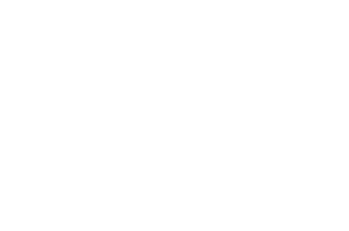

In [575]:
b = 1
vis_scores = [score[b].detach() for score in scene_tree["object_scores"][1:]]
vis_connections = [connect[b] for connect in scene_tree["connections"][1:]]


visualize_tree(vis_scores, vis_connections, scale = 1.618)


tensor([0.0000, 0.8324, 0.0000], grad_fn=<SelectBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.8324], grad_fn=<SelectBackward0>)
tensor([0.3188, 0.0666, 0.1317, 0.3238, 0.6440, 0.8001, 0.8324],
       grad_fn=<SelectBackward0>)
Max: 0.7991997003555298 Min: 0.5568751096725464


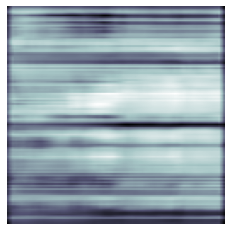

Max: 0.6652861833572388 Min: 0.4635654091835022


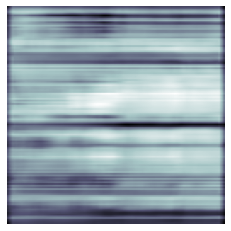

Max: 0.5538111329078674 Min: 0.3858906030654907


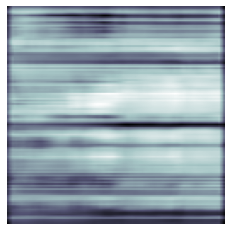

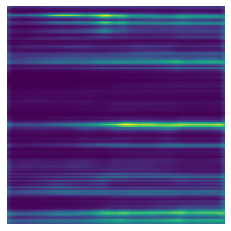

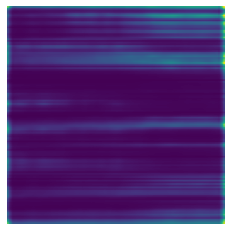

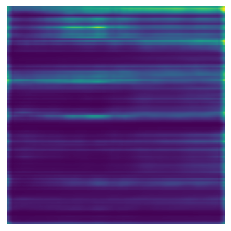

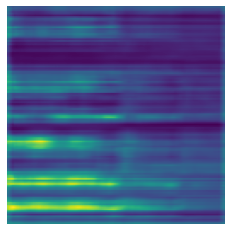

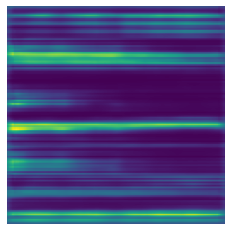

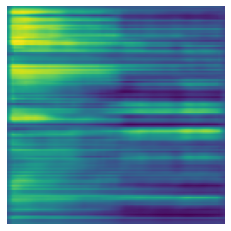

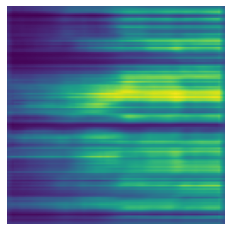

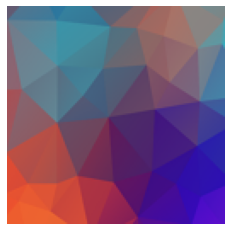

In [576]:

def calculate_masks(scores, connections):
    all_masks = []
    for i in range(len(connections)):
        curr_mask = scores[i+1].unsqueeze(-1)
        for connection in reversed(connections[:i+1]):
            curr_mask = torch.bmm(connection, curr_mask) # [BxNxM],[BxM]
        all_masks.append(curr_mask)
    return all_masks

vis_score = scene_tree["object_scores"]
#vis_score[-1][0][1] = 0.5
print(vis_score[-1][0])
print(vis_score[-2][0])
print(vis_score[-3][0])
all_masks = calculate_masks(vis_score,scene_tree["connections"])

for mask in all_masks:
    plt.axis("off")
    plt.imshow(mask[0].reshape(128,128).detach(), cmap = "bone")
    print("Max:",float(mask[0].max()),"Min:",float(mask[0].min()))
    plt.show()

plt.axis("off")
mask = scene_tree["connections"][0].reshape(2,128,128,7).detach()
for i in range(7):
    plt.axis("off")
    plt.imshow(mask[0,:,:,i])
    plt.show()

plt.axis("off")
plt.imshow(sample["image"][0])

In [ ]:
# [Visualize Predicate Segmentation]
kwargs = {}
q = "filter(scene(), container)"
q = "scene()"
q = model.executor.parse(q)
o = model.executor(q, **kwargs)

In [560]:
def visualize_tree(scores, connections, scale = 1.2):
    fig = plt.figure("tree-visualize",frameon = False)
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    plt.axis("off")
    x_locs = []; y_locs = []
    for i,score in enumerate(reversed(scores)):
        num_nodes = len(score)
        # calculate scores each node
        #print(score.sigmoid())
        #score = (score.sigmoid() + 0.5).int()
        #scores = score.sigmoid()
        score = torch.clamp(score,0.05,1)

        y_positions = [-scale*(i+1) / 2.0] * num_nodes
        x_positions = np.linspace(-scale**(i+1), scale**(i+1), num_nodes)
        if num_nodes == 1: x_positions = [0.0]
        x_locs.append(x_positions); y_locs.append(y_positions)
        
        plt.scatter(x_positions, y_positions, alpha = score, color = 'white', linewidths=2.0)
    for k,connection in enumerate(reversed(connections)):
        connection = connection
        
        lower_node_num = len(x_locs[k])
        upper_node_num = len(x_locs[k+1])
        for i in range(lower_node_num):
            for j in range(upper_node_num):
                plt.plot( [x_locs[k][i],x_locs[k+1][j]], [y_locs[k][i], y_locs[k+1][j]], color = "white" ,alpha = float(connection[j][i]))
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)